<a href="https://colab.research.google.com/github/mathocosta/TCC/blob/master/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização com o K-Means


## Configuração Inicial
Abaixo estão as configurações feitas para ter acesso aos arquivos no Drive. Será solicitado um código de autorização antes de ter acesso.

In [1]:
import os
from google.colab import drive

# Prepara os arquivos do drive
drive.mount('/content/drive')

# Caminho para os arquivos da análise
base_folder = '/content/drive/My Drive/TCC/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Carregando modelo do GloVe
Abaixo é carregado o modelo de embeddings a partir do arquivo do GloVe baixado e salvo na pasta do Google Drive. O método retorna um dicionário onde as chaves são as palavras e os valores são as representações dessas palavras.

In [2]:
import numpy as np

def load_GloVe_model(glove_file):
    print("Carregando modelo do GloVe...")
    
    with open(glove_file, encoding = "utf8") as f:
        content = f.readlines()
      
    model = {}
    for line in content:
        split_line = line.split(" ")
        word = split_line[0]
        embedding = np.array([float(val) for val in split_line[1:]])
        model[word] = embedding
  
    print("Finalizado.",len(model)," palavras carregadas")
  
    return model

glove_filename = os.path.join(base_folder, 'glove_embeddings/glove_s50.txt')
glove_model = load_GloVe_model(glove_filename)


Carregando modelo do GloVe...
Finalizado. 929606  palavras carregadas


## Carregando os textos

Aqui ocorre o carregamento dos textos usados para a análise diretamente da pasta no Google Drive.

In [3]:
def texts_from_folder(data_path):
    print("Carregando textos para análise...")
    texts = []
    for r, d, f in os.walk(data_path):
        for file in f:
            if '.txt' in file:
                text = open(os.path.join(r, file)).read()
                texts.append(text)

    return texts

samples_folder_path = os.path.join(base_folder, '300_textos')
sample_texts = texts_from_folder(samples_folder_path)

print("{} textos carregados".format(len(sample_texts)))


Carregando textos para análise...
300 textos carregados


## Processamento dos textos
Abaixo ocorre o processamento dos textos. Cada etapa está explicada separadamente.


### Pré-processamento
Antes dos outros procedimentos é feito um pré-processamento nas palavras para remover os caracteres especiais e deixar todas os caracteres em minúsculo.

In [4]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

# Pacotes para serem carregados:
nltk.download('averaged_perceptron_tagger')
nltk.download('floresta')
nltk.download('mac_morpho')
nltk.download('machado')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopwords_and_punctuation = set(stopwords.words('portuguese') + list(punctuation))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Unzipping corpora/floresta.zip.
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [0]:
from nltk.tokenize import word_tokenize

def prepare(text):
    words = []
    for word in word_tokenize(text):
        word = word.lower()
        empty_word = not word
        if not empty_word:
            words.append(word)

    return ' '.join(words)

processed_texts = [prepare(text) for text in sample_texts]


### Criação do vocabulário com o TFIDF

É criado um vocabulário de palavras mais importantes nos textos utilizando a técnica TFIDF, esse passo tem como objetivo remover as *stop words*, que são palavras inúteis para a análise. Isso também faz com que menos palavras sejam convertidas para suas representações vetoriais, otimizando o sistema.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def sorted_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key = lambda x: (x[1], x[0]), reverse = True)

def topn_from_vector(feature_names, sorted_items, topn = 1000):
    # Restringe os índices aos top-n itens do vetor
    if len(sorted_items) > topn:
        sorted_items = sorted_items[:topn]
    
    # Seleciona somente as palavras
    topn_words = []
    for index, _ in sorted_items:
        feature_value = feature_names[index]
        topn_words.append(feature_value)

    return topn_words

def topn_from_vector(feature_names, sorted_items, topn = 1000):    
    # Restringe os índices aos top-n itens do vetor
    if len(sorted_items) > topn:
        sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # Indice da palavra e tf-idf correspondente
    for index, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[index])

    # Dicionário onde a chave é a palavra e o valor o tf-idf
    words_and_weight = {}
    for index in range(len(feature_vals)):
        words_and_weight[feature_vals[index]] = score_vals[index]
    
    return words_and_weight

count_vectorizer = CountVectorizer(
    max_df = 0.3,
    analyzer = 'word', 
    max_features = 10000, 
    stop_words = stopwords_and_punctuation
)

word_count_vector = count_vectorizer.fit_transform(processed_texts)
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(word_count_vector)

topn_words_from_texts = []
for text in processed_texts:
    text_word_count = count_vectorizer.transform([text])
    text_tfidf_vector = tfidf_transformer.transform(text_word_count)
    feature_names = count_vectorizer.get_feature_names()
    topn_words_from_texts.append(
        topn_from_vector(feature_names, sorted_coo(text_tfidf_vector.tocoo()))
    )


### Representação vetorial dos textos

Nessa etapa, o objetivo é obter uma representação vetorial de uma sentença de palavras, no caso, do texto completo. Por isso, é obtida a representação de cada palavra individualmente e adicionada a um vetor único para representar o texto por completo. Depois, é feita a normalização de todas representações dos textos.

In [0]:
# Transforma as palavras nas representações vetoriais e calcula um
# vetor resultante para representar o texto.
def text_vectorizer(text_words, model):
    text_vector = []
    word_counter = 0
    for word in text_words:
        try:
            if word_counter == 0:
                text_vector = model[word]
            else:
                text_vector = np.add(text_vector, model[word])

            word_counter += 1

        # Erro de quando uma key não está presente no modelo
        except (KeyError):
            continue

    return np.true_divide(text_vector, word_counter)

# # Transforma as palavras nas representações vetoriais e concatena
# # os vetores para formar um resultante que representa o texto
# def vectorize_words(text_words, model):
#     text_vector = []
#     for word in text_words:
#         try:
#             text_vector = np.hstack((text_vector, model[word]))

#         # Erro de quando uma key não está presente no modelo
#         except (KeyError):
#             continue
            
#     return text_vector

# Normaliza um conjunto de vetores de todos os textos. Se baseia no maior de 
# todos para que todos tenham a mesma quantidade de elementos
# def pad(matrix):
#     max_value = np.amax([vector.size for vector in matrix])
#     X_pad = []
#     for vector in matrix:
#         X_pad.append(np.pad(vector, (0, max_value - vector.size), 'constant'))
#     return X_pad

X = []
for words_and_weight in topn_words_from_texts:
    # Precisa dessa verificação pois alguns textos vieram vazios
    text_words = list(words_and_weight.keys())
    empty_text = not text_words
    if not empty_text:
        text_vector = text_vectorizer(text_words, glove_model)
        X.append(text_vector)


## Clusterização

### Execução do K-Means

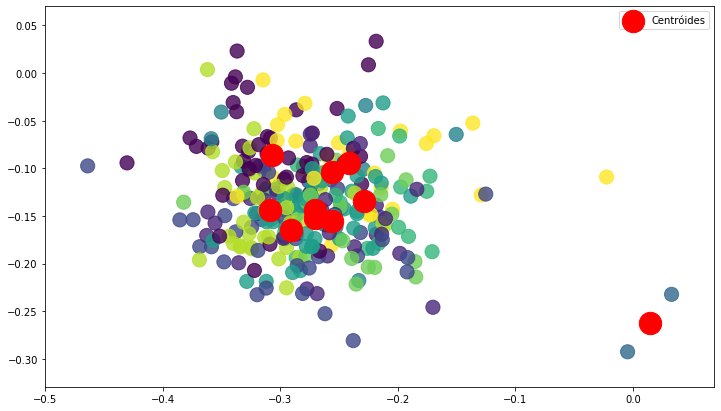

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

XArray = np.asarray(X)
plt.rcParams['figure.figsize'] = (12, 7) 
plt.scatter(XArray[:, 0], XArray[:, 1], s = 200, c = y_kmeans, alpha = 0.8)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s = 500, c = 'red', label = 'Centróides')
# plt.title('Clusters e Centróides')
plt.legend()
plt.show()


### Elbow Method

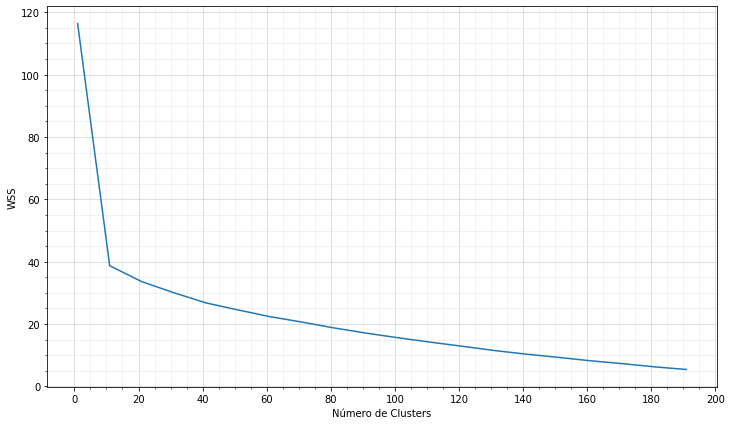

In [0]:
import matplotlib.pyplot as plt

wcss = []
elbowRange = range(1, 200, 10)

for i in elbowRange:
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

major_ticks = np.arange(0, 201, 20)
minor_ticks = np.arange(0, 201, 5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.rcParams['figure.figsize'] = (12, 7) 
plt.plot(elbowRange, wcss)
# plt.title('Método Elbow até 100 clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()


# Visualização e análise dos resultados
Nessa seção são descritos os procedimentos feitos para visualizar os dados e analisá-los.

(23, 4)


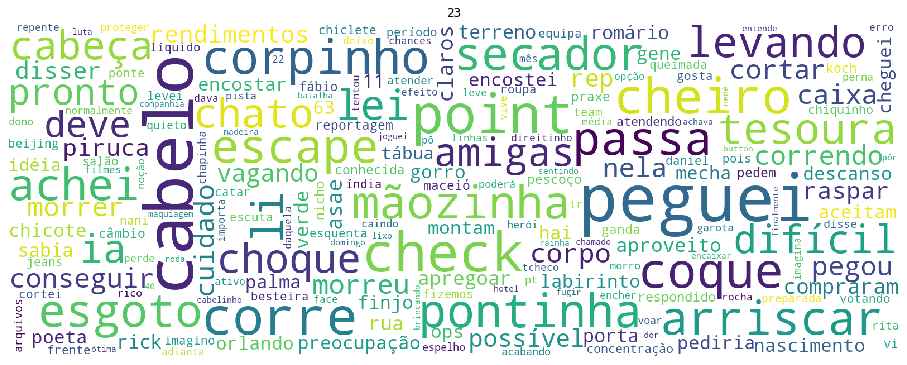

(179, 4)


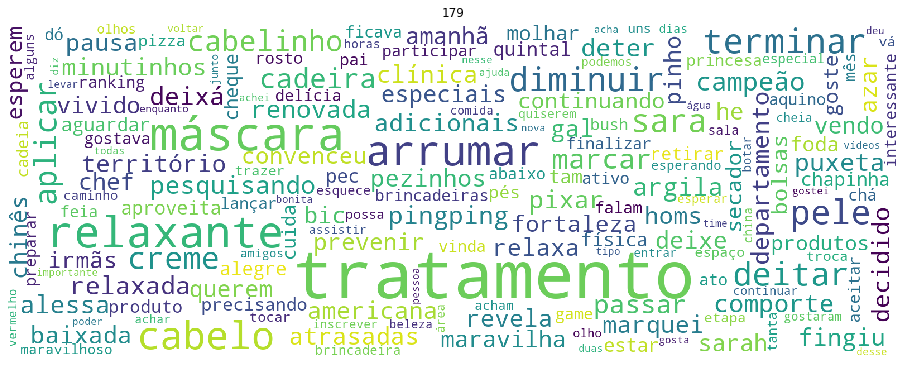

(236, 4)


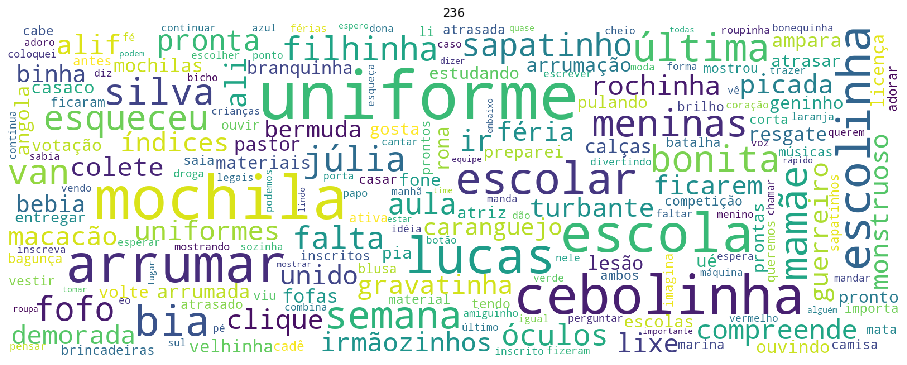

In [28]:
import random
from wordcloud import WordCloud

def find_other_text(cluster):
    selected_object = ()
    current_cluster = (cluster == 0) if 1 else 0
    while current_cluster != cluster:
        selected_object = random.choice(list(enumerate(y_kmeans)))
        current_cluster = selected_object[1]
    
    return selected_object

def show_wordcloud(wc_image, identifier):
    plt.figure(figsize=(16,9))
    plt.imshow(wc_image)
    plt.axis("off")
    plt.title(identifier)
    plt.show()

# first_text = random.choice(list(enumerate(y_kmeans)))
first_text = (23, 4)
second_text = (179, 4)
third_text = (236, 4)

wc = WordCloud(
    max_font_size=120, 
    width=1600, 
    height=600, 
    background_color='white', 
    stopwords=stopwords_and_punctuation
)

print(first_text)
# show_wordcloud(wc.generate(processed_texts[first_text[0]]))
show_wordcloud(wc.generate_from_frequencies(topn_words_from_texts[first_text[0]]), first_text[0])

print(second_text)
show_wordcloud(wc.generate_from_frequencies(topn_words_from_texts[second_text[0]]), second_text[0])

print(third_text)
show_wordcloud(wc.generate_from_frequencies(topn_words_from_texts[third_text[0]]), third_text[0])
# [print(index) for index, cluster in enumerate(y_kmeans) if cluster == 7]

In [33]:

# Obtém a contagem de elementos nos clusters
def cluster_count():
    cluster_count = [0] * 10
    for index, cluster in enumerate(y_kmeans):
        cluster_count[cluster] += 1

    return cluster_count

# Retorna uma lista com os índices dos elementos de um cluster
def elements_of_cluster(target):
    return [index for index, cluster in enumerate(y_kmeans) if cluster == target]

# Retorna o identificador do cluster do elemento
def cluster_of_element(wanted_index):
    for index, cluster in enumerate(y_kmeans):
        if index == wanted_index:
            return cluster
    
    return -1

print(cluster_count())
elements_of_cluster(4)

[47, 32, 41, 2, 8, 48, 17, 24, 38, 28]


2